# Modeling with Feature Engineered Features

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from predict_test_data import predict_test_data
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
train = pd.read_csv('../data/cleaned/train_final.csv')
test = pd.read_csv('../data/cleaned/test_final.csv')
wc_playoffs_train = pd.read_csv('../data/cleaned/wc_playoffs_final.csv')

To begin, let's just naively use all the features we have feature engineered.

In [3]:
columns = ['overall_diff', 'attack_away_defence_home_diff', 'attack_diff',
           'attack_home_defence_away_diff', 'defence_diff', 'midfield_diff',
           'rank_diff', 'prestige_diff', 'growth_diff', 'full_age_diff',
           'start_age_diff', 'value_euros_millions_diff',
           'wage_euros_thousands_diff', 'goalkeeper_overall_diff',
           'bup_dribbling_diff', 'bup_passing_diff', 'bup_speed_diff',
           'cc_crossing_diff', 'cc_passing_diff', 'cc_shooting_diff',
           'd_aggresion_diff', 'd_pressure_diff', 'd_width_diff', 
           'gdp_diff', 'is_home', 'raw_gdp_diff', 
           'wins_past_1_games_diff', 'wins_home_against_away_1_games', 
           'wins_past_2_games_diff', 'wins_home_against_away_2_games', 
           'wins_past_3_games_diff', 'wins_home_against_away_3_games', 
           'wins_past_4_games_diff', 'wins_home_against_away_4_games', 
           'wins_past_5_games_diff', 'wins_home_against_away_5_games', 
           'score_past_1_games_diff', 'score_conceded_past_1_games_diff']

train = train[columns + ['home_win']]
test = test[columns  + ['home_win', 'home_win_no_pk']]
wc_train = wc_playoffs_train[columns + ['home_win']]


In [4]:
#Same seed as baseline to ensure same train and validation sets so that comparisons are valid.
np.random.seed(14)
X_train, X_valid = train_test_split(train, test_size = 0.2)
y_train = X_train['home_win'].ravel()
X_train = X_train.drop(['home_win'], axis = 1)
y_valid= X_valid['home_win'].ravel()
X_valid = X_valid.drop(['home_win'], axis = 1)
y_test = test['home_win'].ravel()
y_test_no_pk = test['home_win_no_pk'].ravel()
X_test = test.drop(['home_win', 'home_win_no_pk'], axis = 1)
y_wc = wc_train['home_win'].ravel()
X_wc = wc_train.drop(['home_win'], axis = 1)

## Fitting the Models

Similar to before, we will fit different classification models on our data and select the one with the best validation accuracy. 

In [5]:
score = {}

In [6]:
lr_model = LogisticRegressionCV(solver = 'lbfgs', max_iter = 5000, cv = 5, multi_class='multinomial').fit(X_train, y_train)
score["Logistic Regression"] = {}
score["Logistic Regression"]["model"] = lr_model
score["Logistic Regression"]["Train Score"] = lr_model.score(X_train, y_train)
score["Logistic Regression"]["Validation Score"] = lr_model.score(X_valid, y_valid)

print("Logistic Regression Train Score: {}".format(score["Logistic Regression"]["Train Score"]))
print("Logistic Regression Validation Score: {}".format(score["Logistic Regression"]["Validation Score"]))

Logistic Regression Train Score: 0.5108767303889256
Logistic Regression Validation Score: 0.5263157894736842


Like before, we first check whether the variances across the three outcomes are equal, and they do seem quite equal.  

In [7]:
train.groupby('home_win').var()

,overall_diff,attack_away_defence_home_diff,attack_diff,attack_home_defence_away_diff,defence_diff,midfield_diff,rank_diff,prestige_diff,growth_diff,full_age_diff,...,wins_past_2_games_diff,wins_home_against_away_2_games,wins_past_3_games_diff,wins_home_against_away_3_games,wins_past_4_games_diff,wins_home_against_away_4_games,wins_past_5_games_diff,wins_home_against_away_5_games,score_past_1_games_diff,score_conceded_past_1_games_diff
home_win,,,,,,,,,,,,,,,,,,,,,
-1,31.393396,38.015113,40.858572,41.497639,37.554931,38.133908,916.793268,25.423806,2.770866,2.489490,...,0.245064,0.111833,0.160882,0.107476,0.128351,0.105429,0.104187,0.105104,3.458817,2.980564
0,36.158215,46.202150,47.654088,46.137393,43.559341,41.798216,960.540851,30.781631,2.593080,2.596855,...,0.226939,0.120386,0.159603,0.113178,0.118615,0.111858,0.097423,0.111192,3.370146,2.821887
1,37.105145,47.913430,49.295727,45.265228,43.509512,42.634416,936.866455,26.985673,2.953428,2.406626,...,0.209184,0.114938,0.149652,0.109862,0.124287,0.107973,0.104463,0.108109,2.869865,2.709063


In [8]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [9]:
score["LDA"] = {}
score["LDA"]["model"] = lda_model
score["LDA"]["Train Score"] = lda_model.score(X_train, y_train)
score["LDA"]["Validation Score"] = lda_model.score(X_valid, y_valid)
print("LDA Train Score: {}".format(score["LDA"]["Train Score"]))
print("LDA Validation Score: {}".format(score["LDA"]["Validation Score"]))

LDA Train Score: 0.5240606460118655
LDA Validation Score: 0.5473684210526316


Likewise, we try out QDA as well.

In [10]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)

In [11]:
score["QDA"] = {}
score["QDA"]['model'] = qda_model
score["QDA"]["Train Score"] = qda_model.score(X_train, y_train)
score["QDA"]["Validation Score"] = qda_model.score(X_valid, y_valid)
print("QDA Train Score: {}".format(score["QDA"]["Train Score"]))
print("QDA Validation Score: {}".format(score["QDA"]["Validation Score"]))

QDA Train Score: 0.5135135135135135
QDA Validation Score: 0.4052631578947368


Wow, QDA is not doing a great job at all. 

We will also try out Random Forest.

In [12]:
rf_params = {'bootstrap': [True, False],
             'max_depth': [3, 5, 10, 20, 30, 40, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4, 10, 20],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [10, 50, 100, 200, 500]}

rf_model = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params,\
                                   n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, verbose=0).fit(X_train, y_train)


In [13]:
score["Random Forest"] = {}
score["Random Forest"]['model'] = rf_model
score["Random Forest"]["Train Score"] = rf_model.score(X_train, y_train)
score["Random Forest"]["Validation Score"] = rf_model.score(X_valid, y_valid)
print("Random Forest Train Score: {}".format(score["Random Forest"]["Train Score"]))
print("Random Forest Validation Score {}".format(score["Random Forest"]["Validation Score"]))

Random Forest Train Score: 0.5510876730388925
Random Forest Validation Score 0.5394736842105263


Finally, XGBoost.

In [14]:
xgb_params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
    }
xgb_model = RandomizedSearchCV(estimator=XGBClassifier(objective='multi:softmax', num_class = 3), param_distributions=xgb_params,\
                                   n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, verbose=0).fit(X_train, y_train)

In [15]:
score["XGBoost"] = {}
score["XGBoost"]['model'] = xgb_model
score["XGBoost"]["Train Score"] = xgb_model.score(X_train, y_train)
score["XGBoost"]["Validation Score"] = xgb_model.score(X_valid, y_valid)
print("XGBoost Train Score: {}".format(score["Random Forest"]["Train Score"]))
print("XGBoost Validation Score {}".format(score["Random Forest"]["Validation Score"]))

XGBoost Train Score: 0.5510876730388925
XGBoost Validation Score 0.5394736842105263


In [16]:
df_result = pd.DataFrame(score).T
df_result

,Train Score,Validation Score,model
Logistic Regression,0.510877,0.526316,"LogisticRegressionCV(Cs=10, class_weight=None,..."
LDA,0.524061,0.547368,"LinearDiscriminantAnalysis(n_components=None, ..."
QDA,0.513514,0.405263,"QuadraticDiscriminantAnalysis(priors=None, reg..."
Random Forest,0.551088,0.539474,"RandomizedSearchCV(cv=5, error_score='raise-de..."
XGBoost,0.575478,0.536842,"RandomizedSearchCV(cv=5, error_score='raise-de..."


In [17]:
model_name = df_result['Validation Score'].astype(float).argmax()
print("We choose the final model to be the one with the highest validation score,\
 which is {} in this case".format(model_name))

We choose the final model to be the one with the highest validation score, which is LDA in this case


In [18]:
wc_model = LogisticRegressionCV(solver = 'lbfgs', max_iter = 5000, cv = 5, multi_class='multinomial').fit(X_wc, y_wc)
test_pred = predict_test_data(X_test, df_result.loc[model_name].model)
test_pred_playoff = predict_test_data(X_test, df_result.loc[model_name].model, False, wc_model)
test_score = accuracy_score(y_test, test_pred)
test_score_playoff = accuracy_score(y_test, test_pred_playoff)
test_score_no_pk = df_result.loc[model_name].model.score(X_test, y_test_no_pk)
print("For the best Model, {}, the test accuracy is {:.3f} at 90 mins".format(model_name, test_score_no_pk))
print("For the best Model, {}, the test accuracy is {:.3f} at end (Softmax)".format(model_name, test_score))
print("For the best Model, {}, the test accuracy is {:.3f} at end (WC Playoff Model)".format(model_name, test_score_playoff))


For the best Model, LDA, the test accuracy is 0.625 at 90 mins
For the best Model, LDA, the test accuracy is 0.656 at end (Softmax)
For the best Model, LDA, the test accuracy is 0.625 at end (WC Playoff Model)


It seems that our model with all the features is an improvement to the baseline model for the test set. However, the lower validation scores in general is a bit concerning. 

## Stacking

We saw that our models in general performed similarly in terms of train/validation. Why not try stacking the models together? We will stack the logistic regression, LDA, QDA, Random Forest, and XGBoost models.

In [19]:
def fit_stack_model(models, X_train, y_train): 
    predictions = []
    for model in models:
        predictions.append(model.predict(X_train))
        
    predictions = np.array(predictions).T
    logit = LogisticRegression(C=1000).fit(predictions, y_train)
    return logit
    
def stack_model_predict(models, stack_model, X, test = False):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))        
    predictions = np.array(predictions).T
    if not test:
        return stack_model.predict(predictions)
    else:
        return stack_model.predict_proba(predictions)

In [20]:
models = df_result['model']
stack_model = fit_stack_model(models, X_train, y_train)
print("Stacking Model Train Score: {}".format(accuracy_score(y_train, stack_model_predict(models, stack_model,
                                                                                         X_train))))
print("Stacking Model Validation Score: {}".format(accuracy_score(y_valid, stack_model_predict(models, stack_model,
                                                                                         X_valid))))

Stacking Model Train Score: 0.5517468688200395
Stacking Model Validation Score: 0.5342105263157895


In [21]:
stack_model_test_pred_prob = stack_model_predict(models, stack_model, X_test, True)
stack_model_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i >= 48) & (np.argmax(val) == 1)
                       else np.argmax(val)-1 for i, val in enumerate(stack_model_test_pred_prob)]
stack_model_test_pred_wc_model = [np.argmax(val) - 1 for val in stack_model_test_pred_prob[:48]] +\
                                list(wc_model.predict(X_test[48:]))
                                    

stack_model_test_acc = accuracy_score(y_test, stack_model_test_pred)
stack_model_test_acc_no_pk = accuracy_score(y_test_no_pk, stack_model_predict(models, stack_model, X_test))
stack_model_test_acc_wc_model = accuracy_score(y_test, stack_model_test_pred_wc_model)


print("Stacking Model Test Score at 90 mins: {}".format(stack_model_test_acc_no_pk))
print("Stacking Model Test Score at end (Softmax): {}".format(stack_model_test_acc))
print("Stacking Model Test Score at end (WC Playoff Model): {}".format(stack_model_test_acc_wc_model))


Stacking Model Test Score at 90 mins: 0.625
Stacking Model Test Score at end (Softmax): 0.640625
Stacking Model Test Score at end (WC Playoff Model): 0.625


It seems that stacking in this case did not really help that much.

We are a bit concerned about the fact that our features are collinear, which potentially affects our predictions. 

## Principal Component Regression

Principal Component Analysis (PCA) is a way to reduce the dimensionality of dataset by summarizing the variation in our data into a set of new predictors called principal components. These principal components are linear combinations of our original predictors. By selecting the top few principal components, we are projecting our dataset into the space defined by these components. This means that we are projecting our dataset onto a space of smaller dimensionality. Importantly, this will help us reduce the multicollinearity that might be affecting our predictions. Each principal component is constructed such that they are orthogonal with each other. Nonetheless, we understand that this will limit the interpretability of our coefficients.

Principal Component Regression (PCR) is basically using the new predictors of reduced dimensionality in a regression problem. In this problem, we inputed the new principal components into our standard logistic regression. In order to decide the number of principal components to keep, we cross-validated the number of principal components that gives us the best validation accuracy. 

In [22]:
# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_wc_scaled = scaler.transform(X_wc)

# PCA on data
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

In [23]:
pcr_train_score = []
pcr_valid_score = []
pcr_wc_score = []

for i in np.arange(1, X_train.shape[1]):
    pca_cv = PCA(n_components=i).fit(X_train_scaled)
    X_train_pca_cv = pca_cv.transform(X_train_scaled)
    X_valid_pca_cv = pca_cv.transform(X_valid_scaled)
    X_test_pca_cv = pca_cv.transform(X_test_scaled)
    X_wc_pca = pca_cv.transform(X_wc_scaled)
    pcr_cv_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                      max_iter = 5000, 
                                      cv = 5, 
                                      multi_class='multinomial').fit(X_train_pca_cv, y_train)
    
    pcr_wc_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                      max_iter = 5000, 
                                      cv = 5, 
                                      multi_class='multinomial').fit(X_wc_pca, y_wc)
    
    
    pcr_train_score.append(pcr_cv_mod.score(X_train_pca_cv, y_train))
    pcr_valid_score.append(pcr_cv_mod.score(X_valid_pca_cv, y_valid))
    pcr_wc_score.append(pcr_wc_mod.score(X_wc_pca, y_wc))

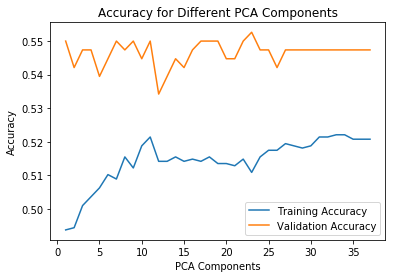

In [24]:
plt.plot(np.arange(1,len(pcr_train_score)+1), pcr_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(pcr_valid_score)+1), pcr_valid_score, label='Validation Accuracy')


plt.title('Accuracy for Different PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.legend();

In [25]:
pca_best_com = np.argmax(pcr_valid_score)+1
print('Best Validation Accuracy Number of Components: {}'.format(pca_best_com))

Best Validation Accuracy Number of Components: 23


In [26]:
# best mod with highest validation accuracy
pca_best = PCA(n_components=pca_best_com).fit(X_train_scaled)
X_train_pca_best = pca_best.transform(X_train_scaled)
X_valid_pca_best = pca_best.transform(X_valid_scaled)

X_wc_pca_best = pca_best.transform(X_wc_scaled)


# fit models
pcr_best_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                    max_iter = 5000, 
                                    cv = 5, 
                                    multi_class='multinomial').fit(X_train_pca_best, y_train)



In [27]:
# Best Validation Accuracy
score["pcr_best"] = {}
score["pcr_best"]["model"] = pcr_best_mod
score["pcr_best"]["Train Score"] = pcr_best_mod.score(X_train_pca_best, y_train)
score["pcr_best"]["Validation Score"] = pcr_best_mod.score(X_valid_pca_best, y_valid)
print("PCR (Best) Train Score: {}".format(score["pcr_best"]["Train Score"]))
print("PCR (Best) Validation Score: {}".format(score["pcr_best"]["Validation Score"]))


PCR (Best) Train Score: 0.5108767303889256
PCR (Best) Validation Score: 0.5526315789473685


In [28]:
# test set
pca_best_com_wc = np.argmax(pcr_wc_score)+1
pca_best_wc = PCA(n_components=pca_best_com_wc).fit(X_wc_scaled)
X_wc_pca_best = pca_best_wc.transform(X_wc_scaled)

pca_wc_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                    max_iter = 5000, 
                                    cv = 5, 
                                    multi_class='multinomial').fit(X_wc_pca_best, y_wc)
X_test_pca_best = pca_best.transform(X_test_scaled)
X_test_pca_best_wc = pca_best_wc.transform(X_test_scaled)
pcr_best_test_pred = predict_test_data(X_test_pca_best, pcr_best_mod)
pcr_best_test_pred_wc_model = list(pcr_best_mod.predict(X_test_pca_best[:48])) + list(pca_wc_mod.predict(X_test_pca_best_wc[48:]))
pcr_best_test_acc = accuracy_score(y_test, pcr_best_test_pred)
pcr_best_test_acc_no_pk = pcr_best_mod.score(X_test_pca_best, y_test_no_pk)
pcr_best_test_acc_wc_model = accuracy_score(y_test, pcr_best_test_pred_wc_model)

print("PCR (Best) Test Score at 90 mins: {}".format(pcr_best_test_acc_no_pk))
print("PCR (Best) Test Score at end (Softmax): {}".format(pcr_best_test_acc))
print("PCR (Best) Test Score at end (WC Playoffs Model): {}".format(pcr_best_test_acc_wc_model))

PCR (Best) Test Score at 90 mins: 0.625
PCR (Best) Test Score at end (Softmax): 0.65625
PCR (Best) Test Score at end (WC Playoffs Model): 0.6875


## Partial Least Squares Regression

Another way that can help us deal with the issues of multicollinearity in our dataset is Partial Least Squares Regression (PLSR). Similar to PCA, PLSR involves projecting the predictors onto orthogonal components. However, the PLSR components are constructed such that they not only approximate the predictors, but are also well correlated with the response. As such, we assume that both the predictors and the response are functions of (reduced) principal components. In this problem, our response variable is a multi-class categorical variable. As such, we could use the PLS2 algorithm which simultaneously decomposes on the multi-class variable directly. We could also use the PLS1 algorithm on each category in our response variable separately. 

To demonstrate how the Partial Least Squares algorithms works, we have included a pseudo-code for PLS1:

Set $X_0 = X$, and $y_0 = y$

for $h = 1, 2, ... r$ do (where r is the dimension of the predictors)

$\hspace{1cm} \mathbf{w_h} = \mathbf{X^T_{h-1}y_{h-1}/y^T_{h-1}y_{h-1}}$ (regress predictors $x_j$ on response $y$)

$\hspace{1cm} ||\mathbf{w_h}|| = 1$ (normalize)

$\hspace{1cm} \mathbf{z_h} = \mathbf{X_{h-1}w_h/w^T_hw_h}$ (regress predictors $x_j$ on weights $w_h$)

$\hspace{1cm} \mathbf{p_h} = \mathbf{X^T_{h-1}z_h/z^T_hz_h}$ (regress predictors $x_j$ on components $z_h$)

$\hspace{1cm} \mathbf{X_h} = \mathbf{X_{h-1} - z_hp^T_h}$ (deflate $X_{h-1}$)

$\hspace{1cm} d_h = \mathbf{y^T_hz_h/z^T_hz_h}$ (regress response $y_h$ onto components $z_h$)

$\hspace{1cm} \mathbf{y_h} = \mathbf{y_{h-1} - d_hz_h}$ (deflate $y_{h-1}$)

end for

The PLS2 algorithm is just an extension for a multi-dimensional response variable.

Importantly, PLS selects components which gives us the greatest reduction in the covariance of our predictors and response. If we represent our components as $\mathbf{z}$, and the response as $\mathbf{y}$, it can be shown that PLSR optimizes with respect to the weights $\mathbf{w}$

$$ \arg\max_{\mathbf{w}} cor^2(\mathbf{y, z})var(\mathbf{y})var(\mathbf{z})$$

It can thus be seen that PLSR tries to maximize the correlation between the components and the response whilst trying to maximize the variance captured by the components. 

This not only allows us to resolve the multicollinearity issues through the creation of orthogonal components just as in PCR, but also allows us to create components that are correlated with the response. It is likely that this might perform even better than PCR.

In [29]:
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_valid_lb = lb.fit_transform(y_valid)
y_wc_lb = lb.fit_transform(y_wc)

In [30]:
plsda1_train_score = []
plsda1_valid_score = []


# PLS1
for i in np.arange(1, X_train.shape[1]):
    # initialize empty array
    train_pred = np.empty(y_train_lb.shape)
    valid_pred = np.empty(y_valid_lb.shape)
    
    plsda1_mod = PLSRegression(n_components=i, scale=False) 
    plsda1_mod.fit(X_train_scaled, y_train_lb[:,0])
    train_pred[:,0] = plsda1_mod.predict(X_train_scaled).ravel()
    valid_pred[:,0] = plsda1_mod.predict(X_valid_scaled).ravel()
    plsda1_mod.fit(X_train_scaled, y_train_lb[:,1])
    train_pred[:,1] = plsda1_mod.predict(X_train_scaled).ravel()
    valid_pred[:,1] = plsda1_mod.predict(X_valid_scaled).ravel()
    plsda1_mod.fit(X_train_scaled, y_train_lb[:,2])
    train_pred[:,2] = plsda1_mod.predict(X_train_scaled).ravel()
    valid_pred[:,2] = plsda1_mod.predict(X_valid_scaled).ravel()

    plsda1_train_score.append(accuracy_score(y_train, np.argmax(train_pred, axis=1) - 1))
    plsda1_valid_score.append(accuracy_score(y_valid, np.argmax(valid_pred, axis=1) - 1))

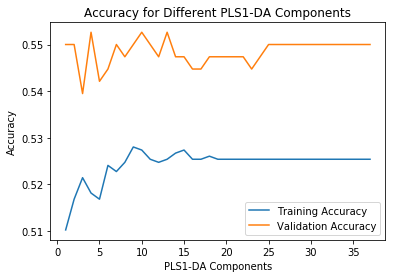

In [31]:
plt.plot(np.arange(1,len(plsda1_train_score)+1), plsda1_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(plsda1_valid_score)+1), plsda1_valid_score, label='Validation Accuracy')

plt.title('Accuracy for Different PLS1-DA Components')
plt.xlabel('PLS1-DA Components')
plt.ylabel('Accuracy')
plt.legend();

In [32]:
plsda1_best_com = np.argmax(plsda1_valid_score)+1
print('Best Validation Accuracy Number of Components: {}'.format(plsda1_best_com))

Best Validation Accuracy Number of Components: 4


In [33]:
# check test accuracy
# initialize arrays
best_train_pred = np.empty(y_train_lb.shape)
best_valid_pred = np.empty(y_valid_lb.shape)
best_test_pred = np.empty((y_test.shape[0],3))

# fit model
plsda1_best_mod = PLSRegression(n_components=plsda1_best_com, scale=False) 

# predict
plsda1_best_mod.fit(X_train_scaled, y_train_lb[:,0])
best_train_pred[:,0] = plsda1_best_mod.predict(X_train_scaled).ravel()
best_valid_pred[:,0] = plsda1_best_mod.predict(X_valid_scaled).ravel()
best_test_pred[:,0] = plsda1_best_mod.predict(X_test_scaled).ravel()

# predict
plsda1_best_mod.fit(X_train_scaled, y_train_lb[:,1])
best_train_pred[:,1] = plsda1_best_mod.predict(X_train_scaled).ravel()
best_valid_pred[:,1] = plsda1_best_mod.predict(X_valid_scaled).ravel()
best_test_pred[:,1] = plsda1_best_mod.predict(X_test_scaled).ravel()

# predict
plsda1_best_mod.fit(X_train_scaled, y_train_lb[:,2])
best_train_pred[:,2] = plsda1_best_mod.predict(X_train_scaled).ravel()
best_valid_pred[:,2] = plsda1_best_mod.predict(X_valid_scaled).ravel()
best_test_pred[:,2] = plsda1_best_mod.predict(X_test_scaled).ravel()




In [34]:
# Best Validation Accuracy
score["plsda1_best"] = {}
score["plsda1_best"]["model"] = plsda1_best_mod
score["plsda1_best"]["Train Score"] = accuracy_score(y_train, np.argmax(best_train_pred, axis=1) - 1)
score["plsda1_best"]["Validation Score"] = accuracy_score(y_valid, np.argmax(best_valid_pred, axis=1) - 1)
print("PLS1-DA (Best) Train Score: {}".format(score["plsda1_best"]["Train Score"]))
print("PLS1-DA (Best) Validation Score: {}".format(score["plsda1_best"]["Validation Score"]))

PLS1-DA (Best) Train Score: 0.5181278839815425
PLS1-DA (Best) Validation Score: 0.5526315789473685


In [35]:
plsda1_best_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i >= 48) & (np.argmax(val) == 1) 
                       else np.argmax(val)-1 for i, val in enumerate(best_test_pred)]

print("PLS1-DA (Best) Test Score at 90 mins: {}".format(accuracy_score(y_test_no_pk, np.argmax(best_test_pred, axis=1) - 1)))
print("PLS1-DA (Best) Test Score at end (Softmax): {}".format(accuracy_score(y_test, plsda1_best_test_pred)))

PLS1-DA (Best) Test Score at 90 mins: 0.625
PLS1-DA (Best) Test Score at end (Softmax): 0.65625


In [36]:
plsda2_train_score = []
plsda2_valid_score = []
plsda_wc_score = []

# PLS2
for i in np.arange(1, X_train.shape[1]):
    plsda2_mod = PLSRegression(n_components=i, scale=False) 
    plsda2_mod.fit(X_train_scaled, y_train_lb)

    plsda2_train_score.append(accuracy_score(y_train, np.argmax(plsda2_mod.predict(X_train_scaled), axis=1) - 1))
    plsda2_valid_score.append(accuracy_score(y_valid, np.argmax(plsda2_mod.predict(X_valid_scaled), axis=1) - 1))
    
    #When there are only two labels, >0 means class 1 have higher probability
    plsda_mod_wc = PLSRegression(n_components=i, scale=False) 
    plsda_mod_wc.fit(X_wc_scaled, y_wc_lb)
    plsda_wc_score.append(accuracy_score(y_wc, list(np.where(plsda_mod_wc.predict(X_wc_scaled) > 0, 1, -1))))

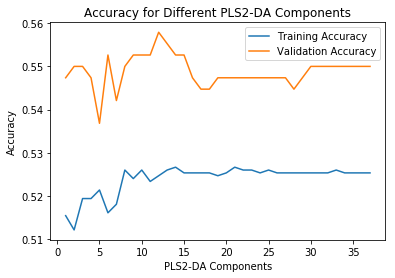

In [37]:
plt.plot(np.arange(1,len(plsda2_train_score)+1), plsda2_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(plsda2_valid_score)+1), plsda2_valid_score, label='Validation Accuracy')

plt.title('Accuracy for Different PLS2-DA Components')
plt.xlabel('PLS2-DA Components')
plt.ylabel('Accuracy')
plt.legend();

In [38]:
plsda2_best_com = np.argmax(plsda2_valid_score)+1
print('Best Validation Accuracy Number of Components: {}'.format(plsda2_best_com))

Best Validation Accuracy Number of Components: 12


In [39]:
plsda2_best_mod = PLSRegression(n_components=plsda2_best_com, scale=False) 
plsda2_best_mod.fit(X_train_scaled, y_train_lb)

PLSRegression(copy=True, max_iter=500, n_components=12, scale=False,
       tol=1e-06)

In [40]:
# Best Validation Accuracy
score["plsda2_best"] = {}
score["plsda2_best"]["model"] = plsda2_best_mod
score["plsda2_best"]["Train Score"] = accuracy_score(y_train, np.argmax(plsda2_best_mod.predict(X_train_scaled), axis=1) - 1)
score["plsda2_best"]["Validation Score"] = accuracy_score(y_valid, np.argmax(plsda2_best_mod.predict(X_valid_scaled), axis=1) - 1)
print("PLS2-DA (Best) Train Score: {}".format(score["plsda2_best"]["Train Score"]))
print("PLS2-DA (Best) Validation Score: {}".format(score["plsda2_best"]["Validation Score"]))

PLS2-DA (Best) Train Score: 0.5247198417930126
PLS2-DA (Best) Validation Score: 0.5578947368421052


In [41]:
plsda2_best_com_wc = np.argmax(plsda_wc_score)+1


plsda2_wc_mod = PLSRegression(n_components=plsda2_best_com_wc, scale=False).fit(X_wc_scaled, y_wc_lb)

plsda2_best_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i >= 48) & (np.argmax(val) == 1)
                       else np.argmax(val)-1 for i, val in enumerate(plsda2_best_mod.predict(X_test_scaled))]

plsda2_best_test_pred_wc = [np.argmax(val)-1 for val in plsda2_best_mod.predict(X_test_scaled[:48])] +\
                        list(np.where(plsda2_wc_mod.predict(X_test_scaled[48:]) > 0, 1, -1))

print("PLS2-DA (Best) Test Score at 90 mins: {}".format(accuracy_score(y_test_no_pk, np.argmax(plsda2_best_mod.predict(X_test_scaled), axis=1) - 1)))
print("PLS2-DA (Best) Test Score at end (Softmax): {}".format(accuracy_score(y_test, plsda2_best_test_pred)))
print("PLS2-DA (Best) Test Score (WC Playoffs Model): {}".format(accuracy_score(y_test, plsda2_best_test_pred_wc)))

PLS2-DA (Best) Test Score at 90 mins: 0.625
PLS2-DA (Best) Test Score at end (Softmax): 0.65625
PLS2-DA (Best) Test Score (WC Playoffs Model): 0.671875


## Analysis

In [42]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [43]:
np.set_printoptions(precision=2)
train_cm1 = confusion_matrix(y_train, np.argmax(best_train_pred, axis=1) - 1)
test_cm1 =  confusion_matrix(y_test, plsda1_best_test_pred)
train_cm2 = confusion_matrix(y_train, np.argmax(plsda2_best_mod.predict(X_train_scaled), axis=1) - 1)
test_cm2 =  confusion_matrix(y_test, plsda2_best_test_pred)

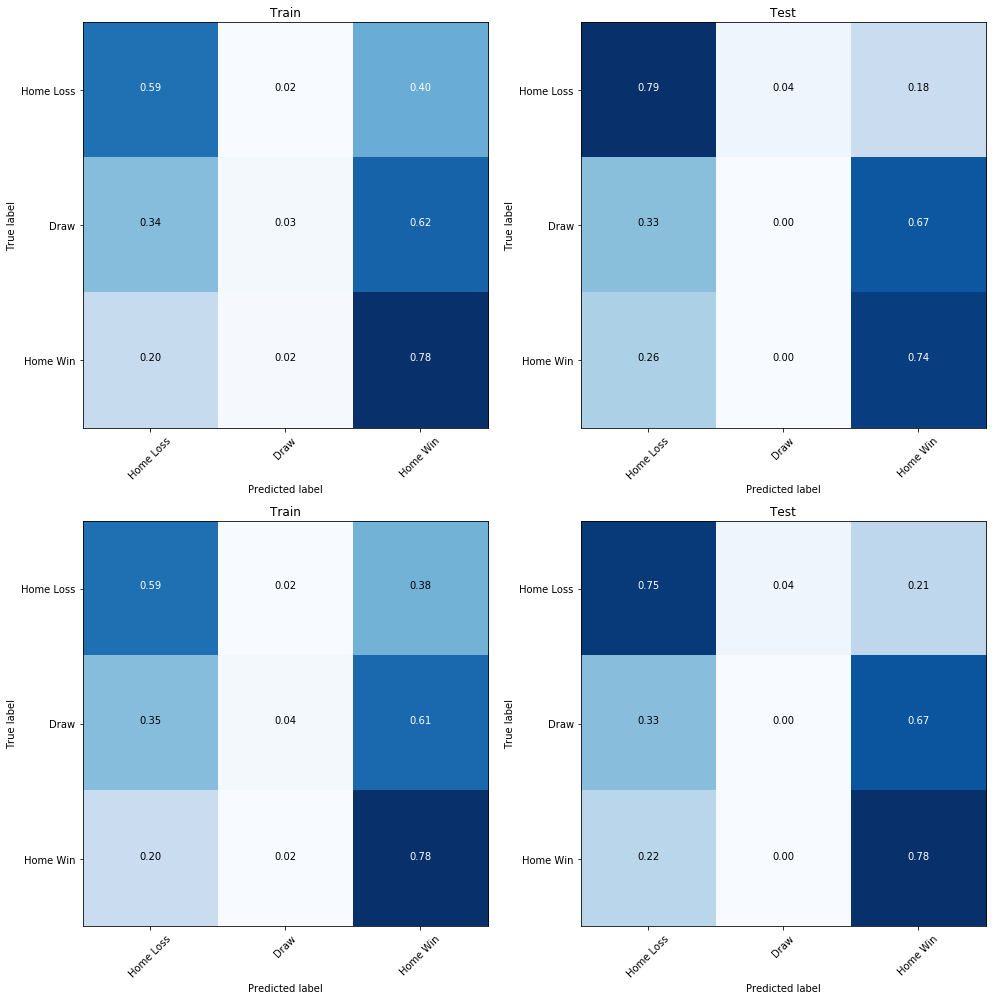

In [44]:
fig, axs = plt.subplots(2, 2, figsize = (14, 14))
plot_confusion_matrix(train_cm1, ['Home Loss', 'Draw', 'Home Win'], axs[0,0], True, 'Train')
plot_confusion_matrix(test_cm1, ['Home Loss', 'Draw', 'Home Win'], axs[0,1], True, 'Test')

plot_confusion_matrix(train_cm2, ['Home Loss', 'Draw', 'Home Win'], axs[1,0], True, 'Train')
plot_confusion_matrix(test_cm2, ['Home Loss', 'Draw', 'Home Win'], axs[1,1], True, 'Test')
plt.tight_layout()

The model is actually predicting some draws now, although still very little. Also, compared to the baseline model, it seems that the model is better in predicting when "home" team loses in the test set. This might be due to some bias of how we feature engineer. Since none of us really were experts in soccer, we chose features that we observed from the World Cup alone, so these features might be biased toward the test set. 